In [250]:
import pandas as pd
import numpy as np
data = pd.read_csv("betodds.csv", header = 0, index_col = 0, encoding = "cp1252", sep = ";")

c:\users\trabelsi\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [251]:
def split_team(s, i):
    if isinstance(s, str):
        teams = s.split(" v ")
        if len(teams) > i:
            return teams[i]
        else:
            return None
    else:
        return None

data["team1"] = data["event_name"].apply(lambda x: split_team(x,0))
data["team2"] = data["event_name"].apply(lambda x:split_team(x, 1))


In [252]:
def pnl_per_runner(data, fee = 0.05, stake = 10):
    data = data.copy()
    targets = ["1","x","2"]
    for target in targets:
        pls = []
        for i, odds in data.iterrows():
                pl = ((float(odds[target]) - 1) * stake) * (1 - fee) if target == odds["winner"] else -stake 
                pls.append(pl)

        data["pnl_"+target] = pls
    return data

data = pnl_per_runner(data)

In [239]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
data_fit = data.iloc[:70000]
data_fit = data_fit[data_fit.astype(str) != "\\N"].dropna()
X = data_fit[["1", "x", "2"]]
Y = data_fit["winner"]
data_out = data.iloc[70001:100000]
data_out = data_out[data_out != "\\N"].dropna()
X_out = data_out[["1", "x", "2"]]
Y_out = data_out["winner"]
clf = MLPClassifier(solver='lbfgs', alpha=1,
                     hidden_layer_sizes=(3, 3, 3), random_state=1)
#RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf.fit(X,Y)


TypeError: Could not compare ['\\N'] with block values

In [253]:
print(clf.score(X, Y))
print(clf.score(X_out, Y_out))

ValueError: could not convert string to float: 'x'

In [241]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# the larger operator will return a boolean array which we will cast as integers for fancy indexing
Y_pred = clf.predict(X_out)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data=cm, columns=["1", "x", "2"], index=["1", "x", "2"])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y_test).mean()
    print('error rate: %.2f' % error_rate)
    return cm

confusion_matrix(Y_out, Y_pred)

ValueError: continuous is not supported

In [255]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
data_COL = data[["team1","team2","1","x","2","pnl_1","pnl_x","pnl_2", "winner"]]
data_fit = data_COL.iloc[:70000]
data_fit = data_fit[data_fit.astype(str) != "\\N"].dropna()
data_out = data_COL.iloc[70001:100000]
data_out = data_out[data_out.astype(str) != "\\N"].dropna()
def prediction(data_fit, data_out, target):
    X = data_fit[["1", "x", "2"]]
    Y = data_fit[target]
    #Y = data_fit["winner"] == "x"
    X_out = data_out[["1", "x", "2"]]
    Y_out = data_out[target]
    #clf = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=3)
    clf = RandomForestRegressor(max_depth=10, n_estimators=20, max_features=3)
    clf.fit(X,Y)
    print(clf.score(X, Y))
    print(clf.score(X_out, Y_out))
    Y_pred = clf.predict(X_out)
    return Y_pred

data_out["pred_1"] = prediction(data_fit, data_out, "pnl_1")
data_out["pred_x"] = prediction(data_fit, data_out, "pnl_x")
data_out["pred_2"] = prediction(data_fit, data_out, "pnl_2")


data_fit["pred_1"] = prediction(data_fit, data_fit, "pnl_1")
data_fit["pred_x"] = prediction(data_fit, data_fit, "pnl_x")
data_fit["pred_2"] = prediction(data_fit, data_fit, "pnl_2")
    #confusion_matrix(Y_out, Y_pred)

0.756393445989
-4.00420071814
0.672371708886
-0.392684202664
0.709023331955
-0.118578754245
0.760964625382
0.760964625382
0.656277082963
0.656277082963
0.701952703447
0.701952703447


In [256]:
def pnl(pred, fee = 0.05, stake = 10):
    data = pred.copy()
    pls = []
    for i, odds in data.iterrows():
        pl = ((float(odds[odds["pred"]]) - 1) * stake) * (1 - fee) if odds["pred"] == odds["winner"] else -stake 
        pls.append(pl)
    data["pnl"] = pls
    data["cum_pnl"] = data["pnl"].cumsum()
    return data

In [257]:
def pnl_target(pred, fee = 0.05, stake = 10, target = "x", max_odds = 2, min_odds = 1.2, scale_with_pred = True):
    data = pred.copy()
    pls = []
    runners  = ["1","x","2"]
    for i, odds in data.iterrows():
        target = "1"
        for r in runners:
            if float(odds["pred_"+r]) > float(odds["pred_"+target]):
                target = r
        if odds["pred_"+target] >0 and float(odds[target])<max_odds  and float(odds[target])>min_odds:
            pl = ((float(odds[target]) - 1) * stake) * (1 - fee) if target == odds["winner"] else -stake 
            pl = pl * odds["pred_"+target] if scale_with_pred else pl
            pls.append(pl)
        else:
            pls.append(0)
    data["pnl"] = pls
    data.index = range(len(data))
    data["cum_pnl"] = data["pnl"].cumsum()
    data["drawdown"] = data["cum_pnl"].cummax() - data["cum_pnl"]
    m = (data[data["pnl"] != 0])["pnl"].mean()
    s = (data[data["pnl"] != 0])["pnl"].std()
    sharpe = m/s
    print(m)
    print(s)
    print(data["drawdown"].max())
    print(sharpe)
    return data

In [260]:
pl = pnl_target(data_out, target = "x", max_odds = 2, min_odds = 1.2, fee = 0.07, scale_with_pred = False, stake = 100)

13.7604880754
58.555038553
787.13
0.235000922474


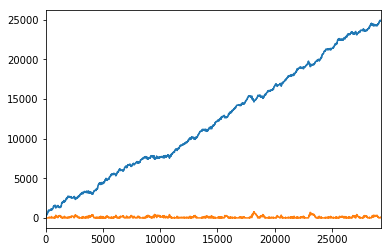

In [261]:
from matplotlib import pyplot as plt
pl["cum_pnl"].plot()
pl["drawdown"].plot()
plt.show()

In [161]:
pl.to_csv("pred.csv", sep = ";")

PermissionError: [Errno 13] Permission denied: 'pred.csv'

In [ ]:
import tensorflow as tf